## Import Packages

In [78]:
#importing some useful packages

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import glob # glob API for importing list of (calibration) images
from copy import copy
from timeit import default_timer as timer
#from line import * # import class Line() from line.py

## Define a class

In [85]:
# Define a class to receive the characteristics of each line detection (object-oriented programming: line is a object)
class Line():
    def __init__(self):
        # was the line detected in the last frame or not
        self.detected = False
        #x values for detected line pixels
        self.cur_fitx = None
        #y values for detected line pixels
        self.cur_fity = None
        # x values of the last N fits of the line
        self.prev_fitx = []
        #polynomial coefficients for the most recent fit
        self.current_poly = [np.array([False])]
        #best polynomial coefficients for the last iteration
        self.prev_poly = [np.array([False])]

    def average_pre_lanes(self):
        tmp = copy(self.prev_fitx)
        tmp.append(self.cur_fitx)
        self.mean_fitx = np.mean(tmp, axis=0)

    def append_fitx(self):
        if len(self.prev_fitx) == N:
            self.prev_fitx.pop(0)
        self.prev_fitx.append(self.mean_fitx)

    def process(self, ploty):
        self.cur_fity = ploty
        self.average_pre_lanes()
        self.append_fitx()
        self.prev_poly = self.current_poly

### Initiating lines (object-oriented programming) with the class

In [86]:
# for monitoring characteristics of detected lines and sanity check them later

left_lane = Line()
right_lane = Line()

frame_width = 1280 # for drawing() (=creating output frame) >> last step of the pipeline
frame_height = 720

LANEWIDTH = 3.7  # highway lane width in US: 3.7 meters
input_scale = 4 # later: what is this?
output_frame_scale = 4 # later: what is this?
N = 5 # buffer previous N lines

## Camera calibration using chessboard images

In [15]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32) 
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # nx=9 and ny=6

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg') # importing the glob API

# Step through the list and search for chessboard corners and if found, add object and image points (needed later in cv.calibrateCamera())
for fname in images:
    img = plt.imread(fname)
    # no cv2.undistort(img, mtx, dist, None) here because cal images are not distorted (only the first one a little bit maybe)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # why? to find corners easily in the next step
                                                # if you are using cv2.imread() or the glob API, as happens here,
                                                # this will read in a BGR image and you should convert to grayscale
                                                # using cv2.COLOR_BGR2GRAY.

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None) # nx=9 and ny=6 (ret=return)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp) # für jedes Bild in der for-Schleife wird dasselbe array (objp) hinzugefügt
        imgpoints.append(corners)

        # Draw and display the corners (this is not necessary but helpful for demonstration purposes)
        # img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # plt.imshow(img)

# Perform camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)

## Helper functions (for both pipelines)

In [48]:
# function that takes an image, object points, and image points, performs the camera calibration, image distortion correction
# and returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    undist = cv2.undistort(img, mtx, dist, None, mtx)  # undist war im Kurs dst (destination)
    return undist

def warp(img, nx, ny, mtx, dist): # to warp >> dt. (ver-)drehen, warped
    # define 4 source points src = np.float32([[,],[,],[,],[,]])
    # Note: you could pick any four of the detected corners as long as those four corners define a rectangle.
    # One especially smart way to do this would be to use four well-chosen corners that were automatically detected
    # during the undistortion steps.
    
    
    
    
    src = np.float32([[  100.,   719.],  # Links unten
                      [  542.,   470.],  # Links oben
                      [  738.,   470.],  # Rechts oben
                      [ 1180.,   719.]]) # Rechts unten
    
    
    '''
    
    source points for A99Munich test video
    src = np.float32([[  235.,   719.], 
                      [  580.,   536.],
                      [  688.,   536.],
                      [ 1003.,   719.]])
                      
    '''
    
        
    # define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    
    dst = np.float32([[ 200.,  720.],
                      [ 200.,    0.],
                      [ 1080.,    0.],
                      [ 1080.,  720.]])
    
        
    # use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # use cv2.warpPerspective() to warp your image to a top-down view
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size)
        
    return warped, M, Minv

def threshold(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Grayscale image? No! Why? Single color needed to calculate derivatives >> "single color" can also mean h-/l- or s-channel! 
    # We already saw that standard grayscaling lost color information for the lane lines. This is while we do not grayscale.
    # Exploring gradients in other colors spaces / color channels shows that l-channel works better
        
    # Sobel x (identifies vertical edges)
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient (Sobel x) # threshold means as much as creating a binary by means of thresholds
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different color
    # The green is the gradient threshold component and the blue is the color channel threshold component
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    return color_binary

def find_lane_pixels(binary_warped):
    
    '''
    Findet mit der sliding windows Methode die Pixel im binary_warped, die zu den Spurlinien gehören und gibt sie wie folgt aus:
    
    leftx >> [308 309 310 ...362 363 364] Liste der x-Koordinaten von Pixeln, die zur left lane gehören müssten
    lefty >> [640 640 640 ... 159 159 159] List der y-Koordinaten von Pixeln, die zur right lane gehören müssten
    rightx >> []
    righty >> []
    
    Außerdem werden auf das Input-Bild die sliding windows (grüner Rahmen) gezeichnet.
    
    '''
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    
    '''
    Die Polynomfunktion wird ermittelt (np.polyfit()) und die sich daraus ergebende Linie gelb eingezeichnet in das Input-image.
    Außerdem werden die zu Beginn der function ermittelten lane pixels rot (left lane) bzw. blau (right lane) eingefärbt.
    (Das Zeichnen der windows (grüner Rahmen) geschieht in der function find_lane_lines, die die sliding windows Methode nutzt.)
    
    
    Mit Hilfe der Pixel, die zu den lane lines gehören müssten (diese werden durch Aufruf der Funktion find_lane_lines()
    in dieser function nochmals separat ermittelt; Ergebnis z.B. leftx >> Liste mit den x-Koordinaten der left lane),
    wird eine passende Polynomfunktion x = A*y**2 + B*y + C ermittelt ("gefittet"). Dabei sind:
        
        left_fit >> [A B C] Polynomkoeffizienten
        right_fit >> dito
        
        ploty >> z.B. [0 1 2 3 4 ... 717 718 719] y-Koordinaten des Polynoms bzw. der sich daraus ergebenden Linie
        
        left_fitx >> z.B. [375 374,8 374,65 374,48 ... 319] x-Koordinaten des Polynoms bzw. der sich daraus ergebenden Kurve
                  >> errechnet sich aus A*y**2 + B*y + C mit y = ploty
        right_fitx >> dito
        
    '''
    
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2) # left_fit beinhaltet die Koeffizienten A, B und C
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0]) # ploty ist eine Liste von [0 1 2 .... 719]
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] # left_fitx ist die gesamte Funktion (x = A*y**2 + B*y + C) des gefundenen, passenden Polynoms "fit"
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0] # Pixel der left lane werden rot dargestellt, Pixel der right lane blau
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow') # x-Koordinaten des Polynoms (left_fitx) und y-Koordinaten des Polynoms (ploty) zum Plotten
    plt.plot(right_fitx, ploty, color='yellow')

    #return out_img
    return out_img, left_fit, right_fit, ploty
    
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    
    '''
    Was ist der Unterschied zur function fit_polynomial()?
    Gemeinsamkeit: Auch hier wird wieder die Polynomfunktion mit np.polyfit() ermittelt: z.B. left_fit >> [A B C] Polynomkoeff. 
    Auch hier werden wieder x- und y-Werte generiert, um sie zu plotten, z.B. ploty
    
    Der entscheidende Unterschied ist der Input der Funktion! Kein Bild wird an die Funktion übergeben sondern direkt die Werte,
    die sich aus der function find_lane_pixels() ergeben. 
    Neue Idee: Wieso nicht innerhalb dieser function diese Werte durch Aufrufen von find_lane_pixels() ermitteln?
    
    Auch der Output ist anders. 
    
    '''
    
    
    # Fit a second order polynomial to each line with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Calc both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    
    # width of the margin around the previous polynomial to search
    margin = 50

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    #Set the area of search based on activated x-values within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx

def measure_curvature_real(ploty, left_fit, right_fit):
    
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad

def full_search(binary_warped, visualization=False):

    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype('uint8')

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = np.floor(100/input_scale)
    # Set minimum number of pixels found to recenter window
    minpix = np.floor(50/input_scale)
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if visualization:
            cv2.rectangle(out_img,(int(win_xleft_low),int(win_y_low)),(int(win_xleft_high),int(win_y_high)),(0,255,0), 2)
            cv2.rectangle(out_img,(int(win_xright_low),int(win_y_low)),(int(win_xright_high),int(win_y_high)),(0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Visualization

    # Generate x and y values for plotting
    if visualization:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        # plt.subplot(1,2,1)
        plt.imshow(out_img)
        # plt.imshow(binary_warped)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim((0, frame_width / input_scale))
        plt.ylim((frame_height / input_scale, 0))
        plt.show()

    return left_fit, right_fit



def window_search(left_fit, right_fit, binary_warped, margin=100, visualization=False):
    # Assume you now have a new warped binary image
    # from the next frame of video (also called "binary_warped")
    # It's easier to find line pixels with windows search
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    if visualization:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        # And you're done! But let's visualize the result here as well
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        out_img = out_img.astype('uint8')
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim((0, frame_width / input_scale))
        plt.ylim((frame_height / input_scale, 0))

        plt.show()

    return left_fit, right_fit

def measure_lane_curvature(ploty, leftx, rightx, visualization=False):

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

     # choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/(frame_height/input_scale) # meters per pixel in y dimension
    xm_per_pix = LANEWIDTH/(700/input_scale) # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    # print(left_curverad, 'm', right_curverad, 'm')

    if leftx[0] - leftx[-1] > 50/input_scale:
        curve_direction = 'Left curve'
    elif leftx[-1] - leftx[0] > 50/input_scale:
        curve_direction = 'Right curve'
    else:
        curve_direction = 'Straight'

    return (left_curverad+right_curverad)/2.0, curve_direction


def off_center(left, mid, right):
    """
    :param left: left lane position
    :param mid:  car position
    :param right: right lane position
    :return: True or False, indicator of off center driving
    """
    a = mid - left
    b = right - mid
    width = right - left

    if a >= b:  # driving right off
        offset = a / width * LANEWIDTH - LANEWIDTH /2.0
    else:       # driving left off
        offset = LANEWIDTH /2.0 - b / width * LANEWIDTH

    return offset


def compute_car_offcenter(ploty, left_fitx, right_fitx, undist):

    # Create an image to draw the lines on
    height = undist.shape[0]
    width = undist.shape[1]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    bottom_l = left_fitx[height-1]
    bottom_r = right_fitx[0]

    offcenter = off_center(bottom_l, width/2.0, bottom_r)

    return offcenter, pts


def create_output_frame(offcenter, pts, undist_ori, fps, curvature, curve_direction, binary_sub, threshold=0.6):
    """
    :param offcenter:
    :param pts:
    :param undist_ori:
    :param fps:
    :param threshold:
    :return:
    """

    undist_ori = cv2.resize(undist_ori, (0,0), fx=1/output_frame_scale, fy=1/output_frame_scale)
    w = undist_ori.shape[1]
    h = undist_ori.shape[0]

    undist_birdview = warper(cv2.resize(undist_ori, (0,0), fx=1/2, fy=1/2), M_b)

    color_warp = np.zeros_like(undist_ori).astype(np.uint8)

    # create a frame to hold every image
    whole_frame = np.zeros((h*2.5,w*2.34, 3), dtype=np.uint8)


    if abs(offcenter) > threshold:  # car is offcenter more than 0.6 m
        # Draw Red lane
        cv2.fillPoly(color_warp, np.int_([pts]), (255, 0, 0)) # red
    else: # Draw Green lane
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))  # green

    newwarp = cv2.warpPerspective(color_warp, M_inv, (int(frame_width/input_scale), int(frame_height/input_scale)))

    # Combine the result with the original image    # result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    newwarp_ = cv2.resize(newwarp,None, fx=input_scale/output_frame_scale, fy=input_scale/output_frame_scale, interpolation = cv2.INTER_LINEAR)

    output = cv2.addWeighted(undist_ori, 1, newwarp_, 0.3, 0)

    ############## generate the combined output frame only for visualization purpose ################
    whole_frame[40:40+h, 20:20+w, :] = undist_ori
    whole_frame[40:40+h, 60+w:60+2*w, :] = output
    whole_frame[220+h/2:220+2*h/2, 20:20+w/2, :] = undist_birdview
    whole_frame[220+h/2:220+2*h/2, 40+w/2:40+w, 0] = cv2.resize((binary_sub*255).astype(np.uint8), (0,0), fx=1/2, fy=1/2)
    whole_frame[220+h/2:220+2*h/2, 40+w/2:40+w, 1] = cv2.resize((binary_sub*255).astype(np.uint8), (0,0), fx=1/2, fy=1/2)
    whole_frame[220+h/2:220+2*h/2, 40+w/2:40+w, 2] = cv2.resize((binary_sub*255).astype(np.uint8), (0,0), fx=1/2, fy=1/2)

    font = cv2.FONT_HERSHEY_SIMPLEX
    if offcenter >= 0:
        offset = offcenter
        direction = 'Right'
    elif offcenter < 0:
        offset = -offcenter
        direction = 'Left'

    info_road = "Road Status"
    info_lane = "Lane info: {0}".format(curve_direction)
    info_cur = "Curvature {:6.1f} m".format(curvature)
    info_offset = "Off center: {0} {1:3.1f}m".format(direction, offset)
    info_framerate = "{0:4.1f} fps".format(fps)
    info_warning = "Warning: offcenter > 0.6m (use higher threshold in real life)"

    cv2.putText(whole_frame, "Departure Warning System with a Monocular Camera", (23,25), font, 0.8, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, "Origin", (22,70), font, 0.6, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, "Augmented", (40+w+25,70), font, 0.6, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, "Bird's View", (22+30,70+35+h), font, 0.6, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, "Lanes", (22+225,70+35+h), font, 0.6, (255,255,0), 1, cv2.LINE_AA)
    cv2.putText(whole_frame, info_road, (40+w+50,70+35+h), font, 0.8, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, info_warning, (35+w,60+h), font, 0.4, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, info_lane, (40+w+50,70+35+40+h), font, 0.8, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, info_cur, (40+w+50,70+35+80+h), font, 0.8, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, info_offset, (40+w+50,70+35+120+h), font, 0.8, (255,255,0), 1,cv2.LINE_AA)
    cv2.putText(whole_frame, info_framerate, (40+w+250,70), font, 0.6, (255,255,0), 1,cv2.LINE_AA)

    return whole_frame


def tracker(binary_sub, ploty, visualization=False):

    left_fit, right_fit = window_search(left_lane.prev_poly, right_lane.prev_poly, binary_sub, margin=100/input_scale, visualization=visualization)

    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    std_value = np.std(right_fitx - left_fitx)
    if std_value < (85 /input_scale):
        left_lane.detected = True
        right_lane.detected = True
        left_lane.current_poly = left_fit
        right_lane.current_poly = right_fit
        left_lane.cur_fitx = left_fitx
        right_lane.cur_fitx = right_fitx
        # global tt
        # tt = tt + 1
    else:
        left_lane.detected = False
        right_lane.detected = False
        left_lane.current_poly = left_lane.prev_poly
        right_lane.current_poly = right_lane.prev_poly
        left_lane.cur_fitx = left_lane.prev_fitx[-1]
        right_lane.cur_fitx = right_lane.prev_fitx[-1]


def detector(binary_sub, ploty, visualization=False):

    left_fit, right_fit = full_search(binary_sub, visualization=visualization)

    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
    std_value = np.std(right_fitx - left_fitx)
    if std_value < (85 /input_scale):
        left_lane.current_poly = left_fit
        right_lane.current_poly = right_fit
        left_lane.cur_fitx = left_fitx
        right_lane.cur_fitx = right_fitx
        left_lane.detected = True
        right_lane.detected = True
    else:
        left_lane.current_poly = left_lane.prev_poly
        right_lane.current_poly = right_lane.prev_poly
        if len(left_lane.prev_fitx) > 0:
            left_lane.cur_fitx = left_lane.prev_fitx[-1]
            right_lane.cur_fitx = right_lane.prev_fitx[-1]
        else:
            left_lane.cur_fitx = left_fitx
            right_lane.cur_fitx = right_fitx
        left_lane.detected = False
        right_lane.detected = False

## Pipeline (test images)

### Read in an image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


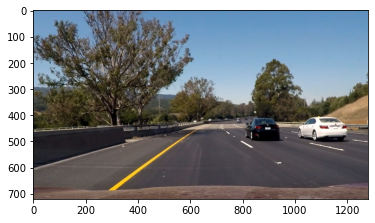

In [18]:
#reading in an image
#img = mpimg.imread('test_images/signs_vehicles_xygrad.png')
#img = mpimg.imread('test_images/straight_lines1.jpg')
#img = mpimg.imread('test_images/straight_lines2.jpg')
#img = mpimg.imread('test_images/test1.jpg')
#img = mpimg.imread('test_images/test2.jpg')
#img = mpimg.imread('test_images/test3.jpg')
#img = mpimg.imread('test_images/test4.jpg')
#img = mpimg.imread('test_images/test5.jpg')
img = mpimg.imread('test_images/test6.jpg')
#img = mpimg.imread('test_images/test_A99Munich_1.jpg')

# ATTENTION: If you are using cv2.imread() or the glob API, this will read in a BGR image and you should convert to grayscale
# (in later image processing steps) using cv2.COLOR_BGR2GRAY.

#printing out some stats and plotting
print('This image is:', type(img), 'with dimensions:', img.shape)
plt.imshow(img)  # single color channel image, e.g. gray , call as plt.imshow(gray, cmap='gray')

### Distortion correction

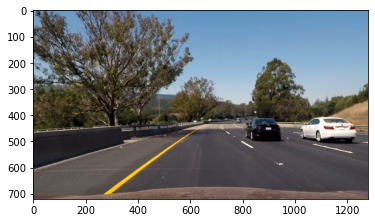

In [19]:
undist = cal_undistort(img, objpoints, imgpoints)
plt.imshow(undist)

### Color & Gradient Threshold

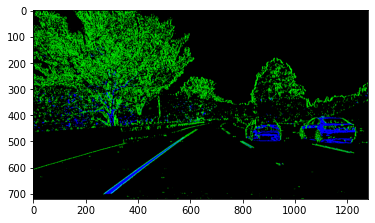

In [20]:
thresholded = threshold(undist)
plt.imshow(thresholded)

### Perspective Transform to "birds-eye view"

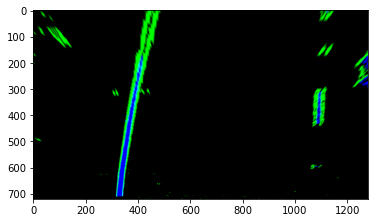

In [21]:
top_down, perspective_M, perspective_Minv = warp(thresholded, 9, 6, mtx, dist)
plt.imshow(top_down)

### Grayscale

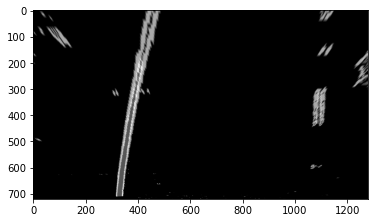

In [22]:
# grayscale
binary_warped = cv2.cvtColor(top_down, cv2.COLOR_BGR2GRAY) # binary_warped entspricht top_down in grau
plt.imshow(binary_warped, cmap="gray")

### Crop the binary image (later: what is this?)

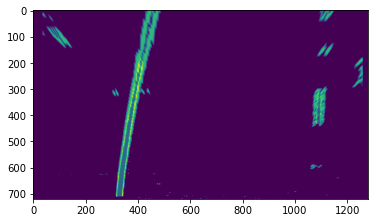

In [28]:
binary_sub = np.zeros_like(binary_warped)
binary_sub[:, int(150/input_scale):int(-80/input_scale)] = binary_warped[:, int(150/input_scale):int(-80/input_scale)]
plt.imshow(binary_sub)

### Start detector or tracker to find lines

In [83]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
visualization = False
print(left_)
if left_line.detected:  # start tracker (am Anfang ist self.detected FALSE >> starts always first with tracker
    tracker(binary_sub, ploty, visualization) # later: Kann nicht das "top-down" verwendet werden und die Schritte "Grayscale"
                                                     # und "Crop the binary image" übersprungen werden?
else:                   # start detector
    detector(binary_sub, ploty, visualization)

### Detect lane pixels implementing sliding windows and fit a polynomial to find the lane boundary

leftx:  [321 322 323 ... 466 467 468]
lefty:  [640 640 640 ...  79  79  79]
left_fit:  [ 1.21292860e-04 -2.70989233e-01  4.61050304e+02] Dies sind die Koeffizienten A, B und C


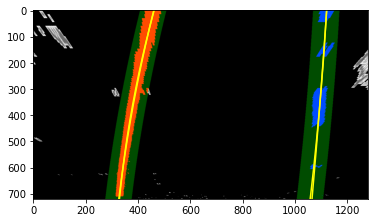

In [10]:
# fit a polynomial to find the lane boundary
out_img, left_fit, right_fit, ploty = fit_polynomial(binary_warped)

# Run image through the pipeline
result, left_fitx, right_fitx = search_around_poly(binary_warped, left_fit, right_fit)

# View the output
plt.imshow(result)

### Determine the curvature of the lane

In [89]:
# average among the previous N frames to get the averaged lanes
left_lane.process(ploty) # process() is a class function
right_lane.process(ploty)

# measure the lane curvature
curvature, curve_direction = measure_lane_curvature(ploty, left_lane.mean_fitx, right_lane.mean_fitx)

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

### Drawing

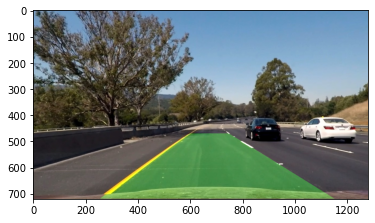

In [12]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
Minv = perspective_Minv
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
lane_colored = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(lane_colored)

## Pipeline (video)

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
def process_image(image):
    '''
    total pipeline from above as a function
    '''
    
    # distortion correction
    undist = cal_undistort(image, objpoints, imgpoints)

    # color & gradient thresholding
    thresholded = threshold(undist)

    # perspective transform to "birds-eye view"
    top_down, perspective_M, perspective_Minv = warp(thresholded, 9, 6, mtx, dist)
    
    # grayscale
    binary_warped = cv2.cvtColor(top_down, cv2.COLOR_BGR2GRAY) # binary_warped entspricht top_down in grau

    # Detect lane pixels implementing sliding windows and fit a polynomial to find the lane boundary
    # fit a polynomial to find the lane boundary
    out_img, left_fit, right_fit, ploty = fit_polynomial(binary_warped)

    # Run image through the pipeline
    result, left_fitx, right_fitx = search_around_poly(binary_warped, left_fit, right_fit)
     
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    Minv = perspective_Minv
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

### Testing on project video:

t:   0%|                                                                            | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video my_output1.mp4.
Moviepy - Writing video my_output1.mp4



Moviepy - Done !
Moviepy - video ready my_output1.mp4
Wall time: 4min 46s


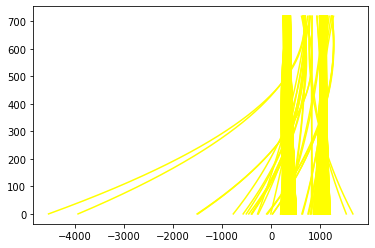

In [23]:
output = 'my_output1.mp4'
## To speed up the testing process, can use pipeline on a shorter subclip of the video with .subclip(start_second,end_second)
clip1 = VideoFileClip("test_videos/project_video.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images
%time clip.write_videofile(output, audio=False)

Play the video inline:

In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### Testing on german highway A99 in Munich

I wanted to know if this algorithm also runs on videos taken by myself. So, what did I do? I took my wife out on a ... nope, I did not take her out on a date but I took her out on the next motorway from our apartment (isn't that even a better date?). She had to drive the car and I recorded a video of the ride on the highway. Then I tested the algorithm on this video.

Note: Before running the pipeline, I had to identify new source points because my video was recorded under different conditions (angles, perspective, etc.). This is why you can find two different source points in my code. Of course, camera calibration needs to be done from scratch.

Here is the result:

t:   0%|                                                                             | 0/290 [00:00<?, ?it/s, now=None]

Moviepy - Building video A99Munich_output.mp4.
Moviepy - Writing video A99Munich_output.mp4



Moviepy - Done !
Moviepy - video ready A99Munich_output.mp4
Wall time: 1min 12s


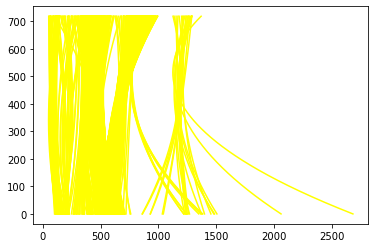

In [26]:
output2 = 'A99Munich_output.mp4'
clip1 = VideoFileClip("test_videos/A99Munich.mp4")
clip = clip1.fl_image(process_image) #NOTE: this function expects color images
%time clip.write_videofile(output2, audio=False)

In [30]:
output2 = 'A99Munich_output.mp4'
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output2))